In [25]:
import csv
import numpy as np
import utils
import hrr_utils
import time


from scipy import spatial
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
%matplotlib inline

N=1000

def genX(verbs):
    X = np.zeros((len(verbs), N)) # Exclusively difference PAST1-PRES1
    PRES1 = np.zeros((len(verbs), N))
    PRES2 = np.zeros((len(verbs), N))
    PAST1 = np.zeros((len(verbs), N))
    PAST2 = np.zeros((len(verbs), N))

    for m, pair in enumerate(verbs):
        past1 = hrr_utils.GetRVClipHash(pair[1], dic1, 3)
        past2 = hrr_utils.GetRVClipHash(pair[1], dic2, 3)
        pres1 = hrr_utils.GetRVClipHash(pair[0], dic1, 3)
        pres2 = hrr_utils.GetRVClipHash(pair[0], dic2, 3)
        PRES1[m] = pres1
        PRES2[m] = pres2
        PAST1[m] = past1
        PAST2[m] = past2

    #X = np.where(PAST1-PRES1 > 0, 1, -1)
    X = PAST1-PRES1
    return X, PRES1, PRES2, PAST1, PAST2

def train(tv, past, present):
    tv += np.multiply(past, present)
    return tv

def reg_train(tv, past, present):
    pred = np.multiply(tv, present)
    #pred = np.where(pred>0, 1, -1)
    #print (sim(pred, past)),
    tv += ((N-sim(pred, past))/float(N)) * np.multiply(past, present)
    return tv

def train_diff(tv, past2, present1, present2):
    tv += np.multiply(present1, past2-present2)
    return tv

def reg_train_diff(tv, past2, present1, present2):
    pred = np.multiply(tv, present1) + present2
    #pred = np.where(pred>0, 1, -1)
    #print (sim(pred, past)),
    tv += ((N-sim(pred, past2))/float(N)) * np.multiply(past2-present2, present1)
    return tv

def sim(x, y):
    if len(x.shape) == 1 or len(y.shape)==1:
        return np.dot(x, y)
    return np.sum(np.multiply(x, y), axis=1)

def graph(x, y1, y2, y3, title=None, xlabel='number of words', ylabel='average dot product'):

    fig = plt.figure()
    plt.plot(x, y1, label="train")
    plt.plot(x, y2, label="test")
    plt.plot(x, y3, label="random")
    fig.suptitle(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=16)
    plt.legend(loc='lower right')
    plt.show()
    #fig.savefig('test.jpg')

In [6]:
reload(utils)

<module 'utils' from 'utils.pyc'>

In [7]:
reg_pres, reg_past, reg_freq = utils.GetRegularVerbs(frequency=1)
irreg_pres, irreg_past, irreg_freq = utils.GetIrregularVerbs(frequency=1)


regular = zip(reg_pres, reg_past, reg_freq)
irregular = zip(irreg_pres, irreg_past, irreg_freq)

train_frac = 2./3.

train_reg = regular[0:int(train_frac*len(regular))]
train_irreg = irregular[0:int(train_frac*len(irregular))]


test_reg = regular[int(train_frac*len(regular)):]
test_irreg = irregular[int(train_frac*len(irregular)):]

dic1 = hrr_utils.GenerateDefaultDictionary(N)
dic2 = hrr_utils.GenerateDefaultDictionary(N)

regular.extend(irregular)
verbs = regular

In [8]:
trainX, trainpres1, trainpres2, trainpast1, trainpast2 = genX(train_reg + train_irreg)
testX, testpres1, testpres2, testpast1, testpast2 = genX(test_reg + test_irreg)

[    0.          1000.          1012.          1018.66666667  1014.           963.2
   958.           971.42857143   998.5         1003.55555556]


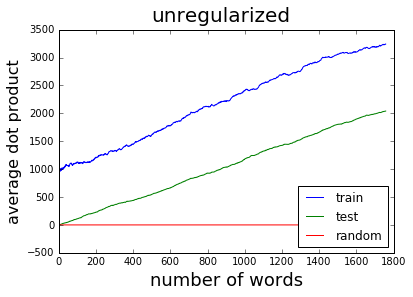

figures/unregularized_trigam_dict-N=1000-W=1758-170310


In [9]:
psi = np.zeros(N)
psi = train(psi, trainpast2[0], trainpres1[0])
random_vecs = np.random.randn(testpast2.shape[0], N)
x = np.arange(1, trainpres1.shape[0]+1, 1)
y1 = np.zeros(trainpres1.shape[0])
y2 = np.zeros(trainpres1.shape[0])
y3 = np.zeros(trainpres1.shape[0])
for k in range(1,len(trainpres1)):#trainpres1.shape[0]):
    train_pred = np.multiply(psi, trainpres1[:k])
    #train_pred = np.where(train_pred>0, 1, -1)
    test_pred = np.multiply(psi, testpres1)
    #test_pred = np.where(test_pred>0, 1, -1)

    y1[k] = sim(train_pred, trainpast2[:k]).mean()
    y2[k] = sim(test_pred, testpast2).mean()
    y3[k] = sim(random_vecs, testpast2).mean()
    
    psi = train(psi, trainpast2[k], trainpres1[k])
print y1[:10]
graph(x,y1,y2,y3,"unregularized")

fname =  ('figures/unregularized_trigam_dict-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)


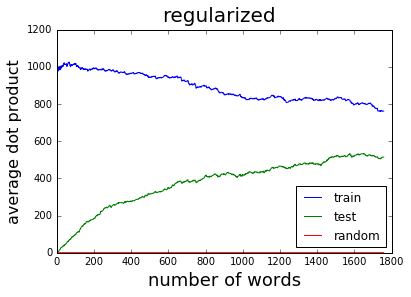

figures/regularized_trigam_dict-N=1000-W=1758-170310


In [10]:
psi = np.zeros(N)
psi = reg_train(psi, trainpast2[0], trainpres1[0])
random_vecs = np.random.randn(testpast2.shape[0], N)
x = np.arange(1, trainpres1.shape[0]+1, 1)
y1 = np.zeros(trainpres1.shape[0])
y2 = np.zeros(trainpres1.shape[0])
y3 = np.zeros(trainpres1.shape[0])
for k in range(1,len(trainpres1)):#trainpres1.shape[0]):
    train_pred = np.multiply(psi, trainpres1[:k])
    #train_pred = np.where(train_pred>0, 1, -1)
    test_pred = np.multiply(psi, testpres1)
    #test_pred = np.where(test_pred>0, 1, -1)

    y1[k] = sim(train_pred, trainpast2[:k]).mean()
    y2[k] = sim(test_pred, testpast2).mean()
    y3[k] = sim(random_vecs, testpast2).mean()
    
    psi = reg_train(psi, trainpast2[k], trainpres1[k])

graph(x,y1,y2,y3,"regularized")

fname =  ('figures/regularized_trigam_dict-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)



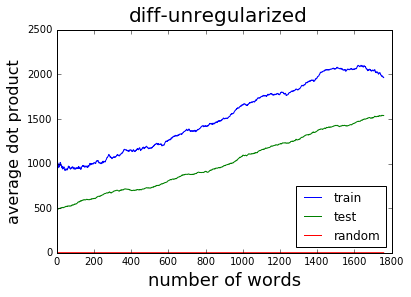

figures/diff_unregularized_trigam_dict-N=1000-W=1758-170310


In [11]:
psi = np.zeros(N)
psi = train_diff(psi, trainpast2[0], trainpres1[0], trainpres2[0])
random_vecs = np.random.randn(testpast2.shape[0], N)
x = np.arange(1, trainpres1.shape[0]+1, 1)
y1 = np.zeros(trainpres1.shape[0])
y2 = np.zeros(trainpres1.shape[0])
y3 = np.zeros(trainpres1.shape[0])
for k in range(1,len(trainpres1)):#trainpres1.shape[0]):
    train_pred = np.multiply(psi, trainpres1[:k]) + trainpres2[:k]
    #train_pred = np.where(train_pred>0, 1, -1)
    test_pred = np.multiply(psi, testpres1) + testpres2
    #test_pred = np.where(test_pred>0, 1, -1)

    y1[k] = sim(train_pred, trainpast2[:k]).mean()
    y2[k] = sim(test_pred, testpast2).mean()
    y3[k] = sim(random_vecs, testpast2).mean()
    
    psi = train_diff(psi, trainpast2[k], trainpres1[k], trainpres2[k])

graph(x,y1,y2,y3,"diff-unregularized")

fname =  ('figures/diff_unregularized_trigam_dict-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)


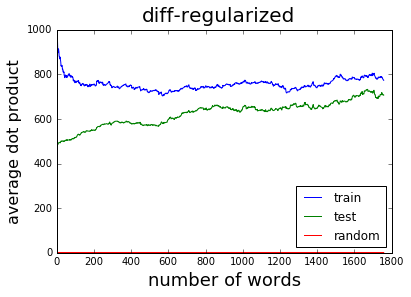

figures/diff_regularized_trigam_dict-N=1000-W=1758-170310


In [12]:
psi = np.zeros(N)
psi = reg_train_diff(psi, trainpast2[0], trainpres1[0], trainpres2[0])
random_vecs = np.random.randn(testpast2.shape[0], N)
x = np.arange(1, trainpres1.shape[0]+1, 1)
y1 = np.zeros(trainpres1.shape[0])
y2 = np.zeros(trainpres1.shape[0])
y3 = np.zeros(trainpres1.shape[0])
for k in range(1,len(trainpres1)):#trainpres1.shape[0]):
    train_pred = np.multiply(psi, trainpres1[:k]) + trainpres2[:k]
    #train_pred = np.where(train_pred>0, 1, -1)
    test_pred = np.multiply(psi, testpres1) + testpres2
    #test_pred = np.where(test_pred>0, 1, -1)

    y1[k] = sim(train_pred, trainpast2[:k]).mean()
    y2[k] = sim(test_pred, testpast2).mean()
    y3[k] = sim(random_vecs, testpast2).mean()
    
    psi = reg_train_diff(psi, trainpast2[k], trainpres1[k], trainpres2[k])

graph(x,y1,y2,y3,"diff-regularized")

fname =  ('figures/diff_regularized_trigam_dict-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)


In [13]:
# Low Rank Time! over rank r
trainXu, trainXs, trainXv = np.linalg.svd(trainX, full_matrices=False)
trainpres1u, trainpres1s, trainpres1v = np.linalg.svd(trainpres1, full_matrices=False)
trainpres2u, trainpres2s, trainpres2v = np.linalg.svd(trainpres2, full_matrices=False)
trainpast1u, trainpast1s, trainpast1v = np.linalg.svd(trainpast1, full_matrices=False)
trainpast2u, trainpast2s, trainpast2v = np.linalg.svd(trainpast2, full_matrices=False)

testXu, testXs, testXv = np.linalg.svd(testX, full_matrices=False)
testpres1u, testpres1s, testpres1v = np.linalg.svd(testpres1, full_matrices=False)
testpres2u, testpres2s, testpres2v = np.linalg.svd(testpres2, full_matrices=False)
testpast1u, testpast1s, testpast1v = np.linalg.svd(testpast1, full_matrices=False)
testpast2u, testpast2s, testpast2v = np.linalg.svd(testpast2, full_matrices=False)

#X = PAST1-PRES1
#    return X, PRES1, PRES2, PAST1, PAST2


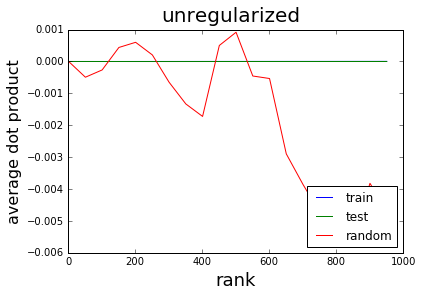

figures/whitened_unregularized_trigam_dict-N=1000-W=1758-170310


In [27]:
random_vecs = np.random.randn(testpast2.shape[0], N)
x = np.arange(1, trainpres1.shape[1]+1, 50) # this is now r
y1 = np.zeros(x.shape[0])
y2 = np.zeros(x.shape[0])
y3 = np.zeros(x.shape[0])
for r in range(x.shape[0]):
    trainXwhitened = np.dot(trainXu[:,:r], trainXv[:r])
    trainpres1whitened = np.dot(trainpres1u[:,:r], trainpres1v[:r])
    trainpres2whitened = np.dot(trainpres2u[:,:r], trainpres2v[:r])
    trainpast1whitened = np.dot(trainpast1u[:,:r], trainpast1v[:r])
    trainpast2whitened = np.dot(trainpast2u[:,:r], trainpast2v[:r])
    
    testXwhitened = np.dot(trainXu[:,:r], trainXv[:r])
    testpres1whitened = np.dot(testpres1u[:,:r], trainpres1v[:r])
    testpres2whitened = np.dot(testpres2u[:,:r], trainpres2v[:r])
    testpast1whitened = np.dot(testpast1u[:,:r], trainpast1v[:r])
    testpast2whitened = np.dot(testpast2u[:,:r], trainpast2v[:r])
    psi = np.zeros(N)
    for k in range(0,len(trainpres1)):
        psi = train(psi, trainpast2whitened[k], trainpres1whitened[k])

    train_pred = np.multiply(psi, trainpres1whitened)
    test_pred = np.multiply(psi, testpres1whitened)
    y1[r] = sim(train_pred, trainpast2whitened).mean()
    y2[r] = sim(test_pred, testpast2whitened).mean()
    y3[r] = sim(random_vecs, testpast2whitened).mean()
      
    
graph(x,y1,y2,y3,"unregularized", "rank")

fname =  ('figures/whitened_unregularized_trigam_dict-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)
